In [1]:
import harmonica as hm
import numpy as np
import verde as vd
import xarray as xr
import magali as mg
import matplotlib.pyplot as plt

In [2]:
sensor_sample_distance = 5.0  # µm
region=[0, 2000, 0, 2000] # µm
spacing=2  # µm

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5


size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)
data

<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[5.13364074, 5.18221685, 5.23151079, ..., 5.57307215, 5.51585922,
        5.4596763 ],
       [5.16055903, 5.20955568, 5.25927886, ..., 5.59389608, 5.5363731 ,
        5.4798876 ],
       [5.18751965, 5.23693792, 5.28709143, ..., 5.61456945, 5.55674146,
        5.49995826],
       ...,
       [3.61324457, 3.66414679, 3.71625136, ..., 0.75151912, 0.75341948,
        0.7552777 ],
       [3.60624839, 3.65703941, 3.70902966, ..., 0.74172533, 0.74368711,
        0.74560616],
       [3.59893397, 3.6496023 , 3.70146622, ..., 0.73203053, 0.73405281,
        0.73603177]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT

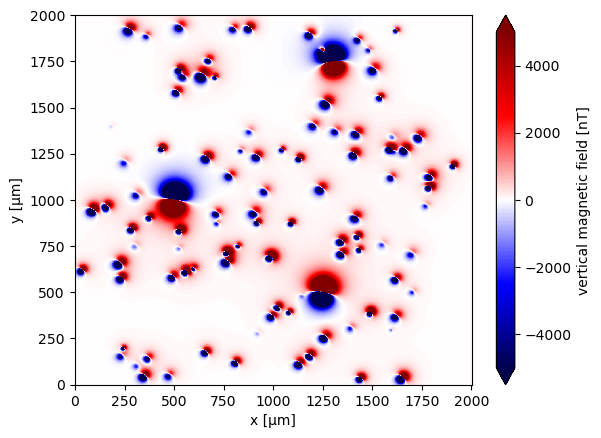

In [3]:
data.plot.pcolormesh(cmap="seismic", vmin=-5000, vmax=5000)

In [4]:
def horizontal_derivatives(data):
    """
    Compute first-order spatial derivatives in the x and y directions.

    Parameters
    ----------
    data : xr.DataArray
        Input data array with coordinates "x" and "y".

    Returns
    -------
    dx : xr.DataArray
        First derivative along the x-direction.
    dy : xr.DataArray
        First derivative along the y-direction.
    """
    dx = hm.derivative_easting(data)
    dy = hm.derivative_northing(data)
    return dx, dy

In [5]:
def estimate_grid_spacing(data):
    """
    Estimate grid spacing as the mean difference in x and y coordinates.

    Parameters
    ----------
    data : xr.DataArray
        Input data array with coordinates "x" and "y".

    Returns
    -------
    spacing : float
        Estimated grid spacing.
    """
    return np.mean([np.abs(data.x[1] - data.x[0]), np.abs(data.y[1] - data.y[0])])

In [6]:
def vertical_derivative(data, spacing):
    """
    Compute the first-order vertical derivative using finite differences.
    
    The vertical derivative is estimated using the difference between an 
    upward-continued and a downward-continued version of the data. This avoids 
    downward continuation, which can amplify noise.

    Parameters
    ----------
    data : xr.DataArray
        Input data array.
    spacing : float
        Grid spacing used for upward and downward continuation.

    Returns
    -------
    dz : xr.DataArray
        First derivative along the z-direction.
    """
    data_up = hm.upward_continuation(data, spacing).assign_coords(x=data.x, y=data.y)
    data_down = hm.upward_continuation(data, -spacing).assign_coords(x=data.x, y=data.y)
    return (data_up - data_down) / (2 * spacing)

In [7]:
def total_gradient_amplitude(dx, dy, dz) -> xr.DataArray:
    """
    Compute the total gradient amplitude from spatial derivatives.

    Parameters
    ----------
    dx : xr.DataArray
        First derivative along the x-direction.
    dy : xr.DataArray
        First derivative along the y-direction.
    dz : xr.DataArray
        First derivative along the z-direction.

    Returns
    -------
    tga : xr.DataArray
        Total gradient amplitude.
    """
    return np.sqrt(dx**2 + dy**2 + dz**2)

In [8]:
dx, dy = horizontal_derivatives(data)

In [9]:
spacing = estimate_grid_spacing(data)

In [10]:
dz = vertical_derivative(data, spacing)

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


In [11]:
tga = total_gradient_amplitude(dx, dy, dz)

In [18]:
data

<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[5.13364074, 5.18221685, 5.23151079, ..., 5.57307215, 5.51585922,
        5.4596763 ],
       [5.16055903, 5.20955568, 5.25927886, ..., 5.59389608, 5.5363731 ,
        5.4798876 ],
       [5.18751965, 5.23693792, 5.28709143, ..., 5.61456945, 5.55674146,
        5.49995826],
       ...,
       [3.61324457, 3.66414679, 3.71625136, ..., 0.75151912, 0.75341948,
        0.7552777 ],
       [3.60624839, 3.65703941, 3.70902966, ..., 0.74172533, 0.74368711,
        0.74560616],
       [3.59893397, 3.6496023 , 3.70146622, ..., 0.73203053, 0.73405281,
        0.73603177]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT

In [23]:
def total_gradient_amplitude_grid(data):
    """
    Compute the total gradient amplitude (TGA) of a given data array.
    
    The function calculates the horizontal and vertical derivatives of the input data and then 
    computes the total gradient amplitude.
    
    Parameters
    ----------
    data : xr.DataArray
        Input data array with coordinates `x` and `y`.
    
    Returns
    -------
    xr.Dataset
        Dataset containing the total gradient amplitude (TGA).    
    """
    dx, dy = horizontal_derivatives(data)
    spacing = estimate_grid_spacing(data)
    dz = vertical_derivative(data, spacing)
    tga = total_gradient_amplitude(dx, dy, dz)
    
    # Assign attributes
    tga.attrs = {"long_name": "Total Gradient Amplitude", "units": "nT/µm"}
    data_tga = xr.Dataset({"tga": tga})

    return data_tga.tga

In [24]:
data_tga = total_gradient_amplitude_grid(data)
data_tga

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.DataArray 'tga' (y: 1001, x: 1001)> Size: 8MB
array([[0.58984431, 1.69998048, 1.26258957, ..., 4.1685332 , 3.6873921 ,
        4.67884954],
       [0.17138938, 0.11392988, 0.1514381 , ..., 0.76894766, 0.79801918,
        0.79520459],
       [0.03504317, 0.46765718, 0.31362114, ..., 0.91180813, 0.74786273,
        1.11388229],
       ...,
       [2.15405791, 0.764715  , 0.24775785, ..., 1.270062  , 0.25289649,
        3.19550781],
       [2.34060488, 0.18868325, 0.70667904, ..., 0.40960382, 1.29046874,
        1.28468264],
       [1.55522931, 2.01996097, 0.73023014, ..., 4.54739652, 3.21612262,
        6.7743837 ]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  Total Gradient Amplitude
    units:      nT/µm

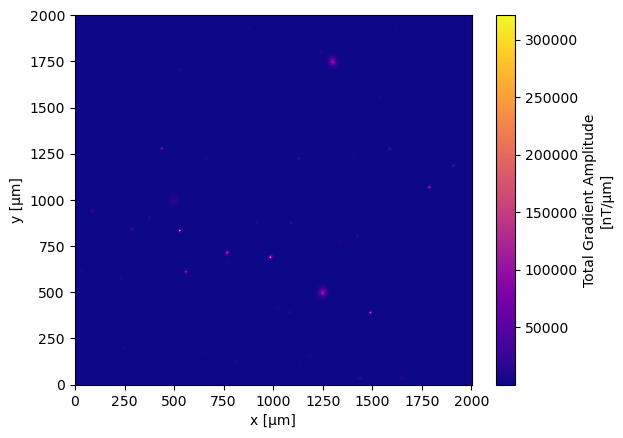

In [25]:
data_tga.plot.pcolormesh(cmap="plasma")